In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/ECG_Project/augmented_ecg_images_balanced.zip'
extract_to = '/content/ecg_dataset'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Check extracted content
print("Top-level folders:", os.listdir(extract_to))


Top-level folders: ['augmented_ecg_images_balanced']


In [ ]:
nested = os.path.join(extract_to, "augmented_ecg_images_balanced")
print("Inside dataset folder:", os.listdir(nested))


Inside dataset folder: ['Myocardial_Infarction', 'Normal', 'Abnormal_Heartbeat', 'History_of_MI']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_path = '/content/ecg_dataset/augmented_ecg_images_balanced'

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=(384, 384),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=(384, 384),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 6564 images belonging to 4 classes.
Found 1640 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load ResNet50 base with ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))
base_model.trainable = False  # Freeze all layers initially

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 390,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 192,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 192,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 192,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 194,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 96,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 96,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 96,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 96,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 96,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 96,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 96,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 96,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 96,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history_warmup = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 85s 353ms/step - accuracy: 0.2645 - loss: 1.8003 - val_accuracy: 0.4598 - val_loss: 1.3104
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 63s 307ms/step - accuracy: 0.3827 - loss: 1.3183 - val_accuracy: 0.4549 - val_loss: 1.2759
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 62s 303ms/step - accuracy: 0.3954 - loss: 1.2971 - val_accuracy: 0.4555 - val_loss: 1.2499
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 61s 297ms/step - accuracy: 0.4318 - loss: 1.2567 - val_accuracy: 0.4927 - val_loss: 1.2173
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 62s 302ms/step - accuracy: 0.4316 - loss: 1.2396 - val_accuracy: 0.4982 - val_loss: 1.2010


In [ ]:
# Unfreeze last 30 layers of ResNet50
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Re-compile with smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 108s 416ms/step - accuracy: 0.5385 - loss: 1.0677 - val_accuracy: 0.6134 - val_loss: 0.9483
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 72s 347ms/step - accuracy: 0.8331 - loss: 0.4745 - val_accuracy: 0.8256 - val_loss: 0.4658
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 389ms/step - accuracy: 0.9082 - loss: 0.2786 - val_accuracy: 0.8848 - val_loss: 0.2916
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 388ms/step - accuracy: 0.9375 - loss: 0.2028 - val_accuracy: 0.8902 - val_loss: 0.2898
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 72s 349ms/step - accuracy: 0.9410 - loss: 0.1750 - val_accuracy: 0.9165 - val_loss: 0.2166
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 90s 388ms/step - accuracy: 0.9527 - loss: 0.1396 - val_accuracy: 0.9055 - val_loss: 0.2712
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 388ms/step - accuracy: 0.9590 - loss: 0.1259 - val_accuracy: 0.9256 - val_loss: 0.2155
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 72s 347ms/step - accuracy: 0.9683 - loss: 

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
model_resnet50.save('resnet50_ecg_model.h5')
print("✅ Model saved as 'resnet50_ecg_model.h5'")


✅ Model saved as 'resnet50_ecg_model.h5'


In [ ]:
from google.colab import files
files.download('resnet50_ecg_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 331ms/step


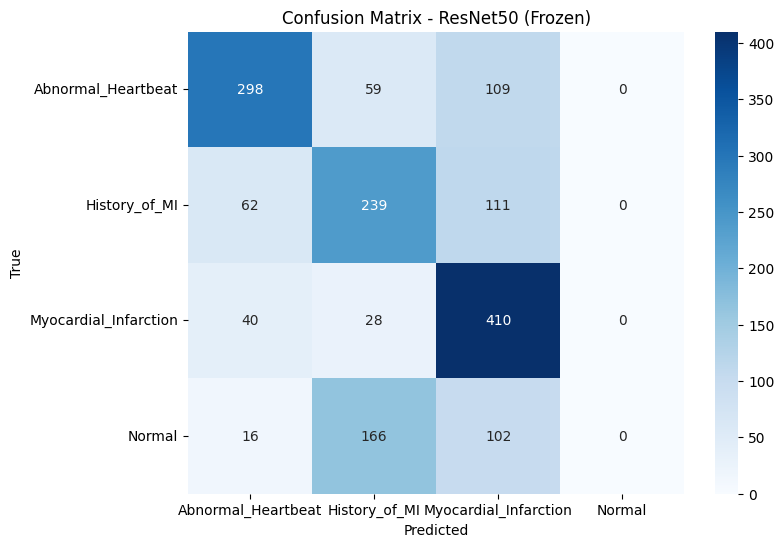

Classification Report:

                       precision    recall  f1-score   support

   Abnormal_Heartbeat       0.72      0.64      0.68       466
        History_of_MI       0.49      0.58      0.53       412
Myocardial_Infarction       0.56      0.86      0.68       478
               Normal       0.00      0.00      0.00       284

             accuracy                           0.58      1640
            macro avg       0.44      0.52      0.47      1640
         weighted avg       0.49      0.58      0.52      1640



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
Y_pred_probs = model_resnet50.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)
Y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - ResNet50 (Frozen)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
from sklearn.metrics import classification_report
report_dict = classification_report(
    Y_true,
    Y_pred_classes,
    target_names=class_labels,
    output_dict=True,
    zero_division=0
)

print("Classification Report:\n")
print(classification_report(Y_true, Y_pred_classes, target_names=class_labels))


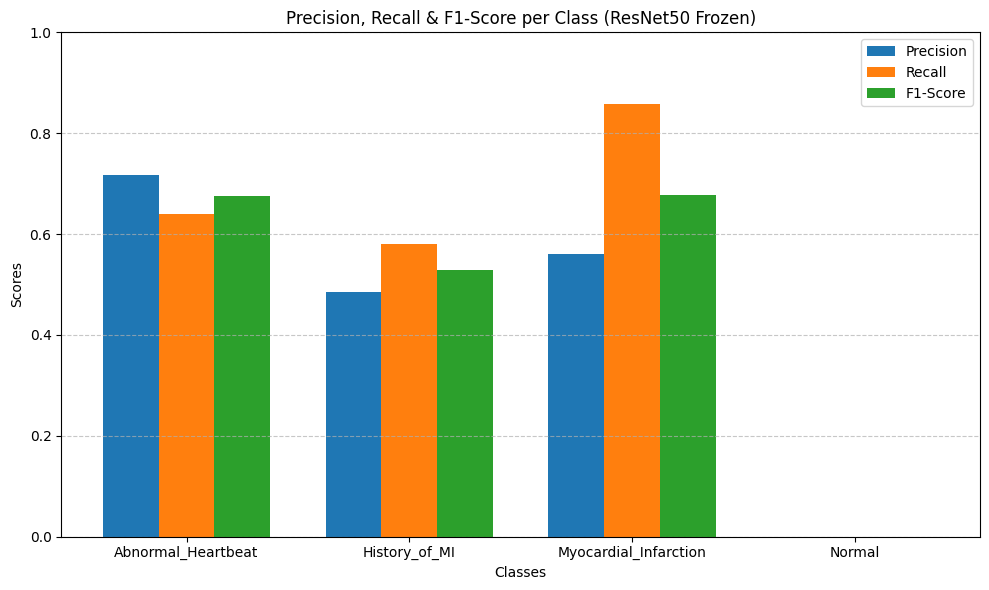

In [ ]:
# Safe parsing of metrics per class (ensures "Normal" shows even if score=0)
precision = []
recall = []
f1_score = []

for label in class_labels:
    if label in report_dict:
        precision.append(report_dict[label]["precision"])
        recall.append(report_dict[label]["recall"])
        f1_score.append(report_dict[label]["f1-score"])
    else:
        precision.append(0.0)
        recall.append(0.0)
        f1_score.append(0.0)

# Bar plot
x = np.arange(len(class_labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall & F1-Score per Class (ResNet50 Frozen)')
plt.xticks(x, class_labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
model_resnet50.save("/content/resnet50_ecg_frozen.h5")
print("ResNet50 model saved successfully!")


ResNet50 model saved successfully!


In [ ]:
import pandas as pd

# Convert training history to DataFrame
history_df = pd.DataFrame(history_resnet.history)

# Save to CSV
history_df.to_csv('/content/resnet50_history.csv', index=False)
print("Training history saved!")


Training history saved!


In [ ]:
model_resnet50.save("/content/resnet50_ecg_frozen.h5")


In [ ]:
from google.colab import files
files.download("/content/resnet50_ecg_frozen.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>